In [15]:
import rasterio as rio
from rasterio.plot import plotting_extent
from glob import glob
import numpy as np
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import re
from skimage.io import imread

In [5]:
bands = ["B4", "B3", "B2"]

In [9]:
# Read data

# Pipe network and leak loc
tuberias = gpd.read_file('../data/shp/Tuberias.shp')
leaks = pd.read_excel('../data/raw/Ordenes Fugas Ejecutadas Dic2022 XY.xlsx')

# Satellite images
images_path = "../data/images/*.tif"
sat_band_path = glob(images_path)
sat_band_path.sort()

# Stack RGB bands
sat_stack, meta = es.stack(sat_band_path, out_path = "../data/stacked.tif")

In [10]:
# Define geometry from coords in leaks dataset
leaks["geometry"] = gpd.points_from_xy(leaks["X"], leaks["Y"])

# Create geopandas df
leaks_gdf = gpd.GeoDataFrame(leaks, geometry = gpd.points_from_xy(leaks["X"], leaks["Y"]))

In [40]:
# Reproject boundary (pipes gdf) to match CRS of the Sentinel images
with rio.open(sat_band_path[0]) as raster_crs:
    raster_profile = raster_crs.profile
    bound_utm13N = tuberias.to_crs(raster_profile["crs"])

extent = plotting_extent(sat_stack[0], raster_profile["transform"])

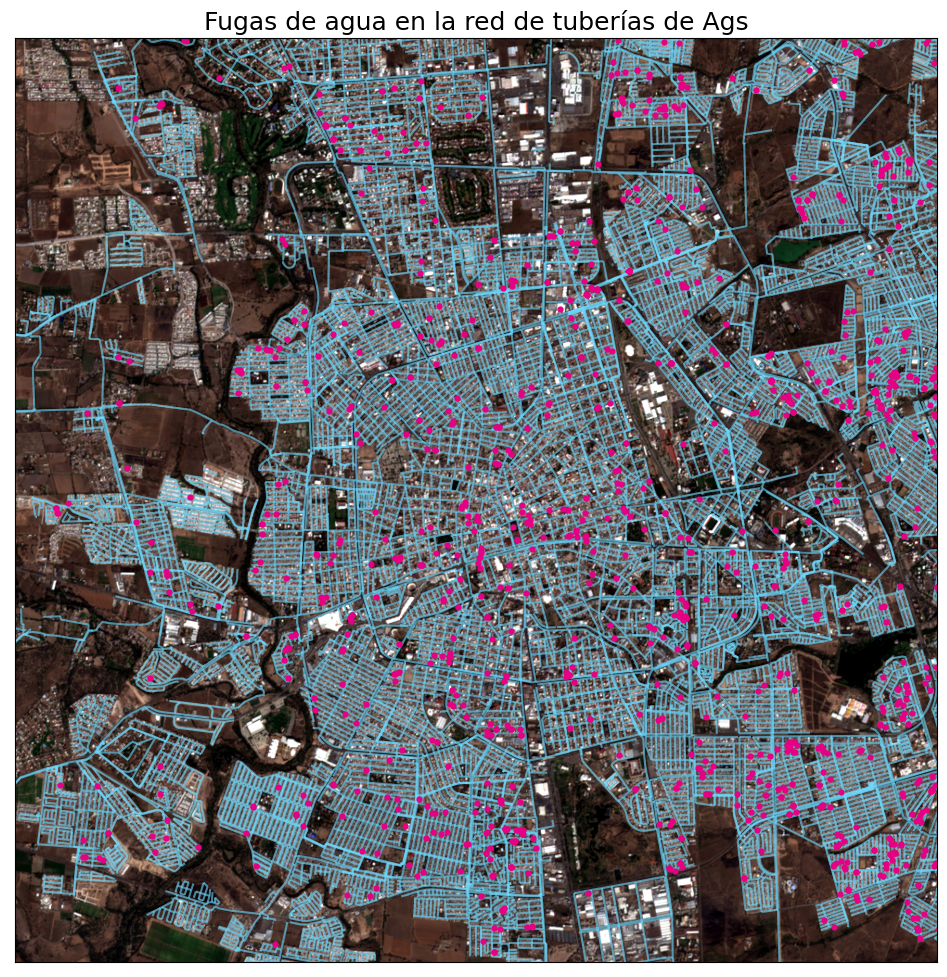

In [41]:
# Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot boundary with high zorder for contrast
tuberias.plot(ax=ax, color="#6FDBFF", alpha = 0.6)
leaks_gdf.plot(ax = ax, color = "#e60083", markersize = 12, zorder = 2)

# Plot CIR image using the raster extent
ep.plot_rgb(
    sat_stack,
    rgb=(2, 1, 0),
    ax=ax,
    extent = extent,
    stretch=True,
    str_clip=0.5,
)
plt.title("Fugas de agua en la red de tuberías de Ags", fontsize = 18)
plt.show()


## EDA for collected images

In [25]:
leaks_clean = pd.read_csv("../data/clean/leaks_clean.csv")

In [51]:
leaks_clean.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'id', 'fecha_de_i',
       'fecha_fina', 'fechaasign', 'fechalegal', 'nombreunid', 'codestado',
       'codtrabajo', 'actividad', 'barrio', 'com1', 'com2', 'causal', 'orden',
       'solicitud', 'cliente', 'producto', 'consecruta', 'codruta', 'x', 'y',
       'id_download', 'sentinel_img_date', 'landsat_img_date', 'date_diff_img',
       'date_diff_leak', 'sentinel_cloud', 'landsat_cloud',
       'id_download_nonleak', 'sentinel_img_date_nonleak',
       'landsat_img_date_nonleak', 'date_diff_img_nonleak',
       'date_diff_leak_nonleak', 'sentinel_cloud_nonleak',
       'landsat_cloud_nonleak'],
      dtype='object')

<AxesSubplot: >

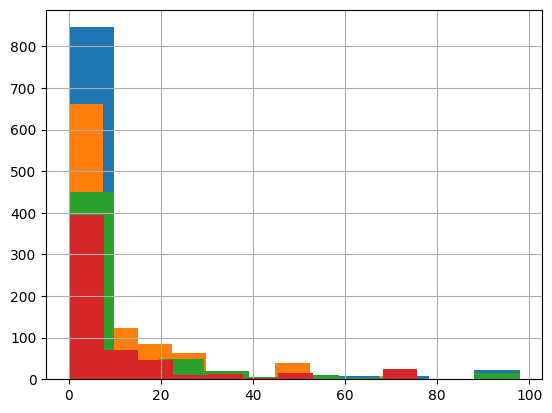

In [30]:
# Plot distribution of cloud coverage for landsat and sentinel images
leaks_clean.sentinel_cloud.hist() # Blue
leaks_clean.landsat_cloud.hist() # Orange

leaks_clean.sentinel_cloud_nonleak.hist() # Green
leaks_clean.landsat_cloud_nonleak.hist() # Red


<AxesSubplot: >

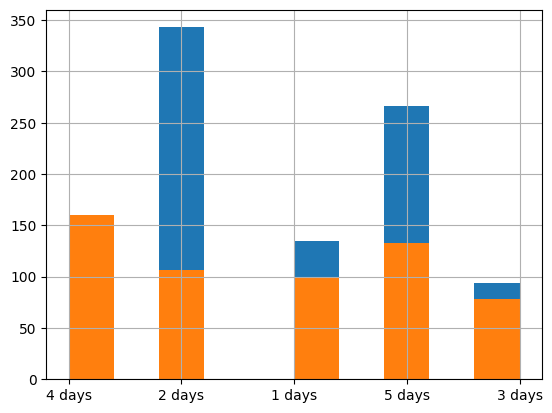

In [32]:
# Plot distribution of days of difference between sentinel and landsat images
leaks_clean.date_diff_img.hist()
leaks_clean.date_diff_img_nonleak.hist()


<AxesSubplot: >

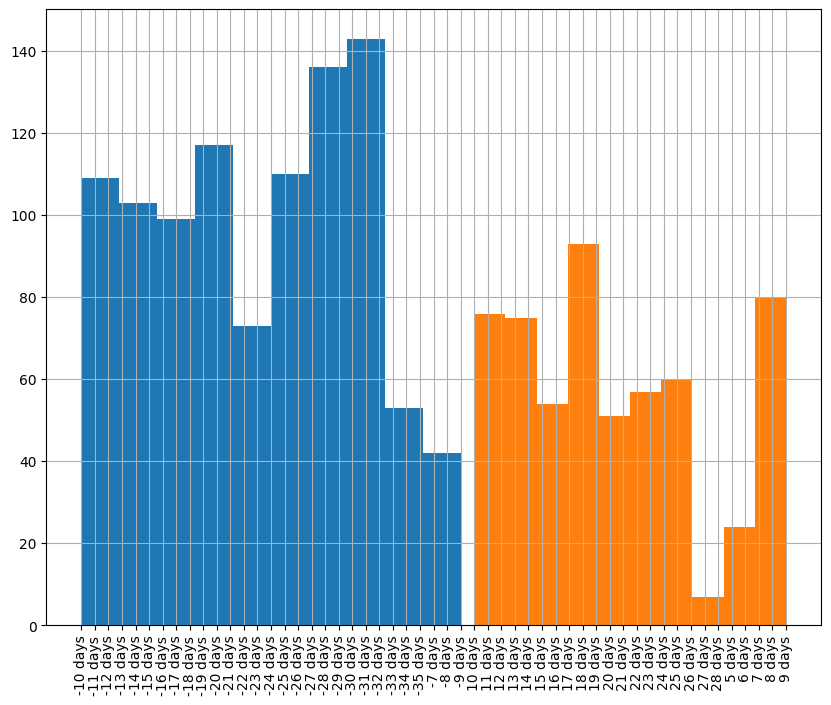

In [50]:
# Plot distribution of days of difference between the collected image and the leak repair
plt.figure(figsize = (10, 8))
leaks_clean.sort_values("date_diff_leak", inplace = False).date_diff_leak.hist(xrot = 90)
leaks_clean.sort_values("date_diff_leak_nonleak", inplace = False).date_diff_leak_nonleak.hist(xrot = 90)

## EDA for tiff files

In [11]:
# Get a sample of tiff bands
patches_bands = glob("../data/patches_raw/leak/S2_i20445d_2020-01-28_12/*B*.tif")

def my_digit_sort(my_list):
   return list(map(int, re.findall(r'(?<=.B)\d+(?=A?.tif)', my_list)))[0]

patches_bands.sort(key = my_digit_sort)
patches_bands.append(glob("../data/patches_raw/leak/S2_i20445d_2020-01-28_12/*WVP*.tif")[0])
patches_bands.append(glob("../data/patches_raw/leak/S2_i20445d_2020-01-28_12/*LST*.tif")[0])
patches_bands

['../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B1.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B2.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B3.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B4.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B5.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B6.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B7.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B8.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QGE.B8A.tif',
 '../data/patches_raw/leak/S2_i20445d_2020-01-28_12\\20200103T172719_20200103T173532_T13QG

In [12]:
# Get each band name
titles = [re.search(r"(?<=T13QGE.)(.*)(?=.tif)", band).group() for band in patches_bands]
titles

# Get path of images
leak_images_paths = glob("../data/patches_clean/leak/*leak*")
nonleak_images_paths = glob("../data/patches_clean/non_leak/*nonleak*")

In [13]:
# Function to order paths by their id
def my_path_sort(my_list):
   return list(map(int, re.findall(r'(?<=leak)\d+(?=.tif)', my_list)))[0]

In [14]:
# Sort paths
leak_images_paths.sort(key = my_path_sort)
nonleak_images_paths.sort(key = my_path_sort)

### Functions to plot multiple bands, lst and nmdi

In [20]:
# Read image
def read_tif(img):
    return imread(img)

In [16]:
# Plot all Sentinel Bands
def norm_bands(tif):
    return (tif - tif.min())/(tif.max() - tif.min())

def plot_bands(leak_tif_path, nonleak_tif_path):
    leak_tif = norm_bands(imread(leak_tif_path))
    nonleak_tif = norm_bands(imread(nonleak_tif_path))

    print("leak")
    ep.plot_bands(
        arr = np.transpose(leak_tif[:, :, :13]), cmap = "gist_earth",
        figsize = (22, 10), cols = 13,
        cbar = True, title = titles[:13],
        vmin = 0, vmax = leak_tif[:, :, :13].max()
    )

    print("nonleak")
    ep.plot_bands(
        arr = np.transpose(nonleak_tif[:, :, :13]), cmap = "gist_earth",
        figsize = (22, 10), cols = 13,
        cbar = True, title = titles[:13],
        vmin = 0, vmax = nonleak_tif[:, :, :13].max()
    )

    plt.show()

In [17]:
# Land Surface Temperature
def plot_lst(leak_tif_path, nonleak_tif_path):
    leak_tif = norm_bands(imread(leak_tif_path))
    nonleak_tif = norm_bands(imread(nonleak_tif_path))
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    fig.colorbar(plt.imshow(leak_tif[:,:,13], cmap = "gnuplot"))
    plt.title("leak")
    
    fig.add_subplot(1, 2, 2)
    fig.colorbar(plt.imshow(nonleak_tif[:,:,13], cmap = "gnuplot"))
    
    plt.title("no leak")

In [22]:
def plot_ndmi(leak_tif_path, nonleak_tif_path):
    leak_tif = imread(leak_tif_path)
    nonleak_tif = imread(nonleak_tif_path)

    moisture_leak = es.normalized_diff(leak_tif[:, :, 7], leak_tif[:, :, 11])
    moisture_nonleak = es.normalized_diff(nonleak_tif[:, :, 7], nonleak_tif[:, :, 11])
    
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    fig.colorbar(plt.imshow(moisture_leak, cmap = "RdYlGn"))
    plt.title("leak")
    
    fig.add_subplot(1, 2, 2)
    fig.colorbar(plt.imshow(moisture_nonleak, cmap = "RdYlGn"))
    
    plt.title("no leak")

### Multiple bands plots

leak


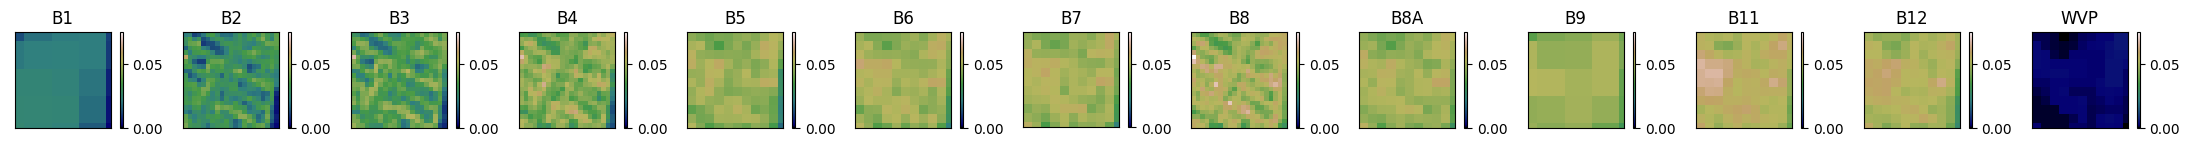

nonleak


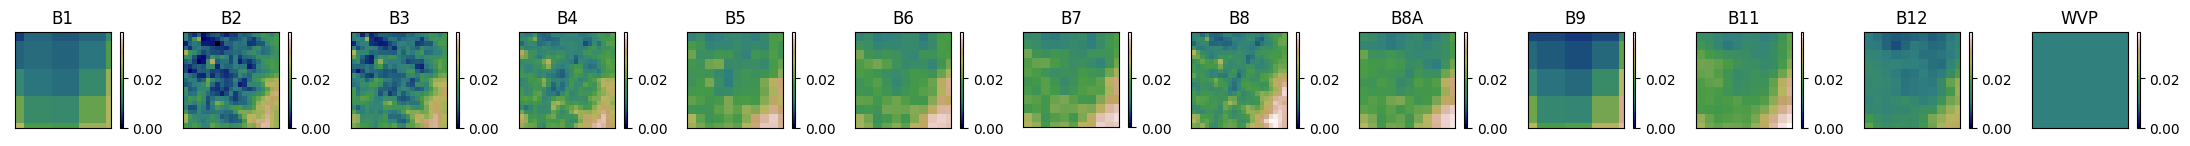

leak


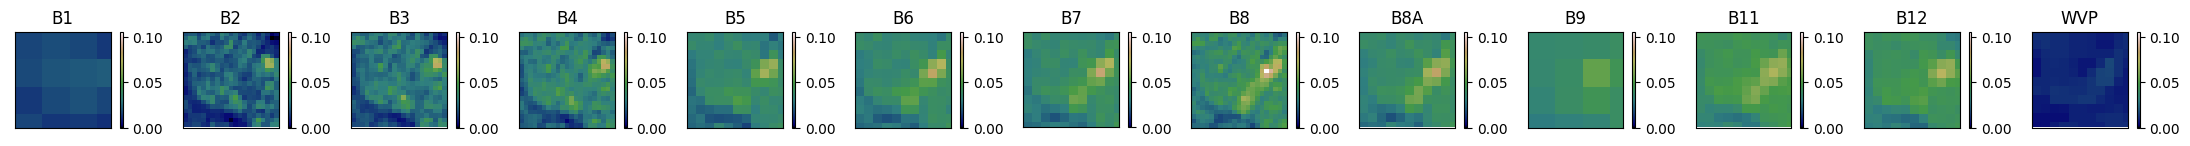

nonleak


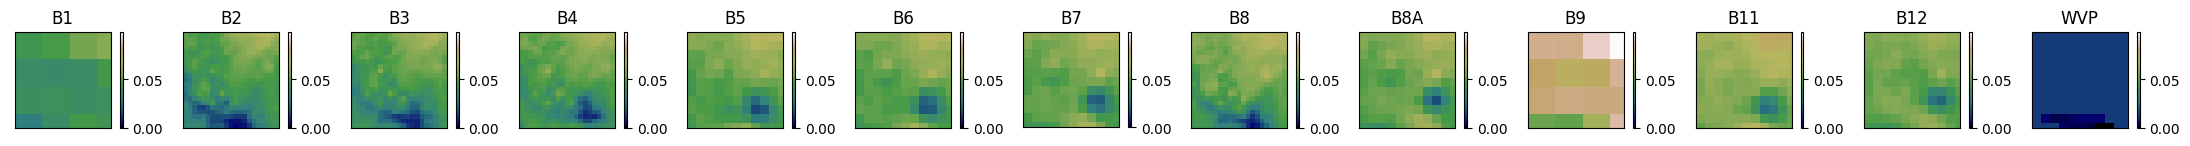

leak


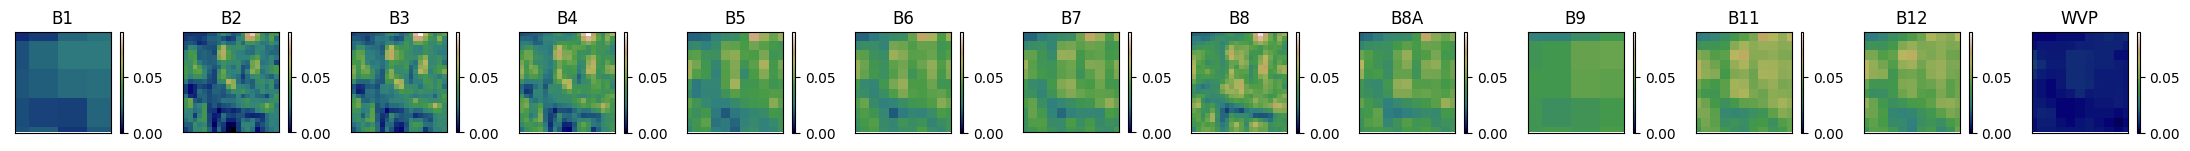

nonleak


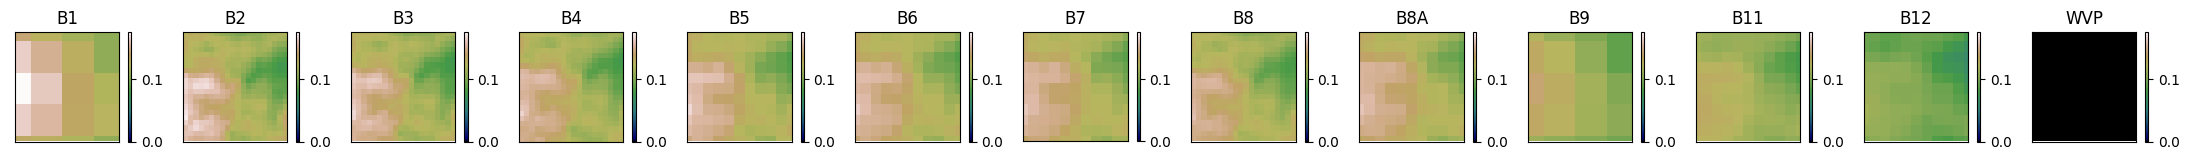

leak


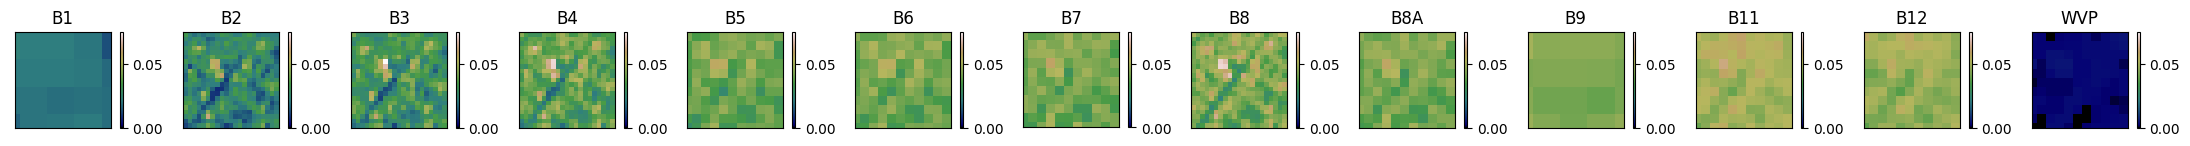

nonleak


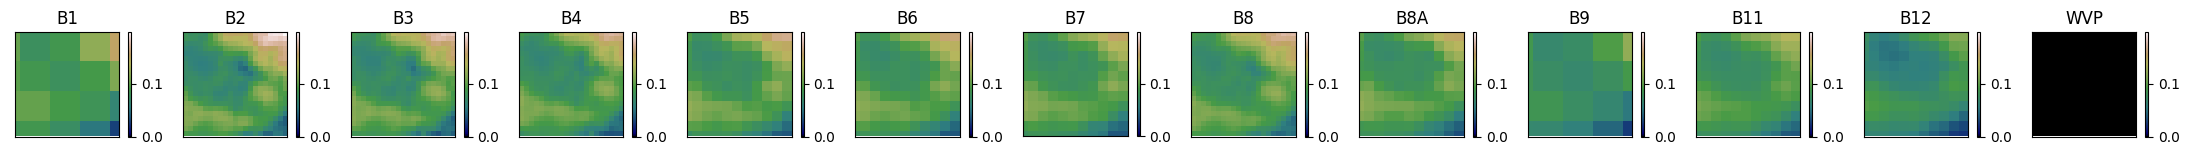

leak


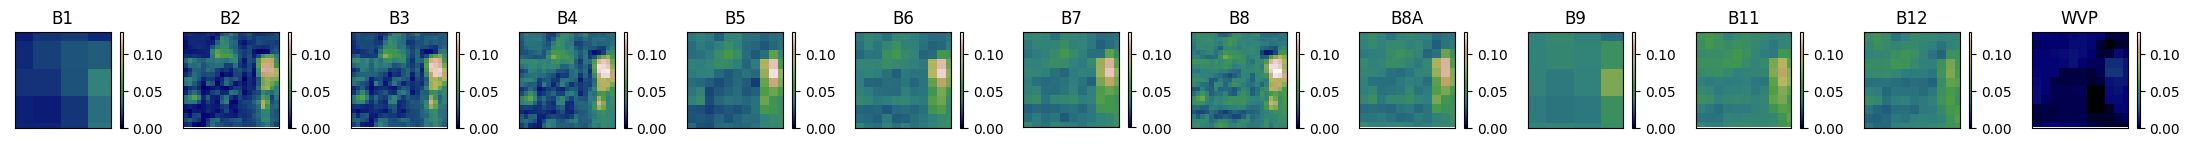

nonleak


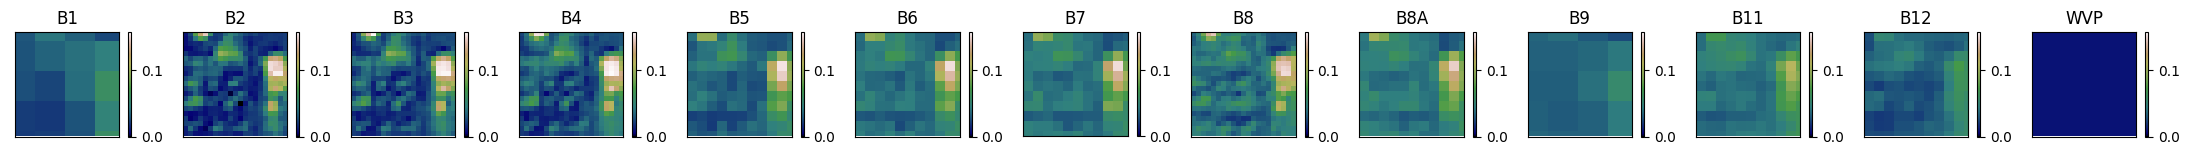

leak


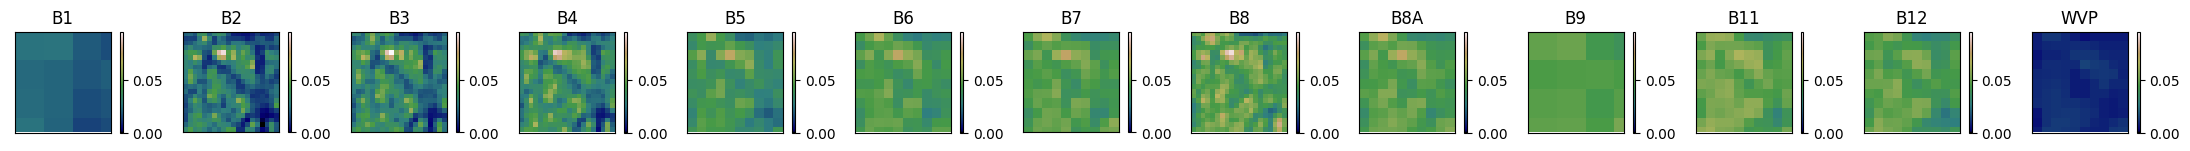

nonleak


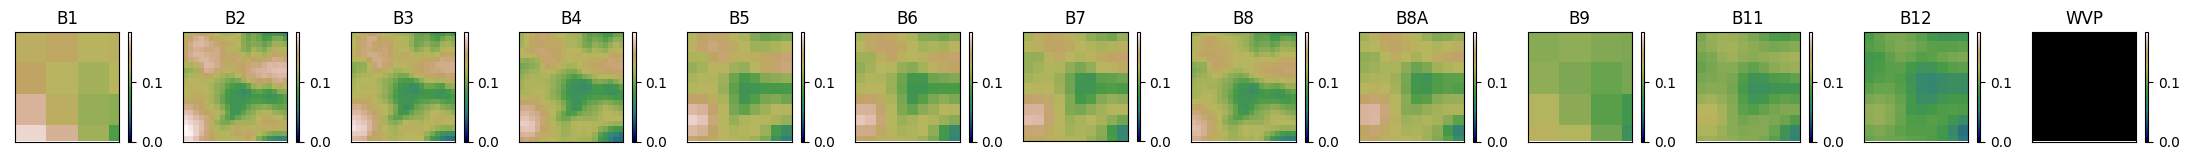

leak


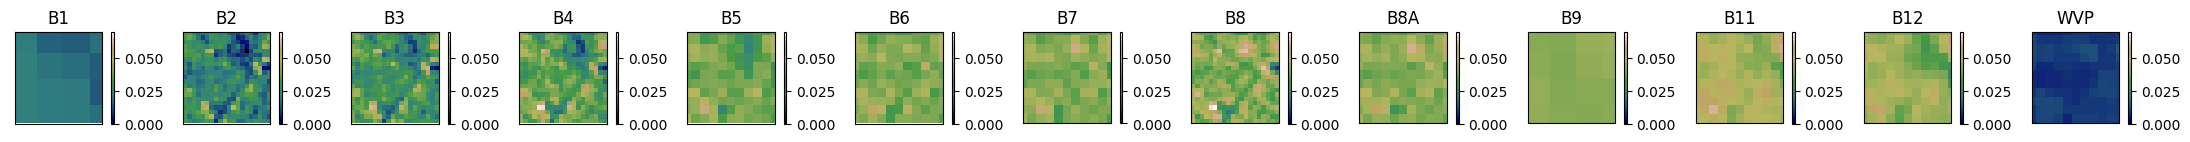

nonleak


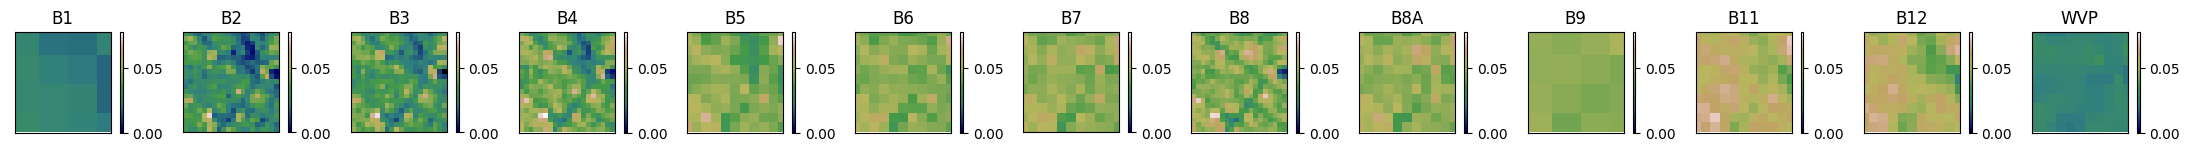

leak


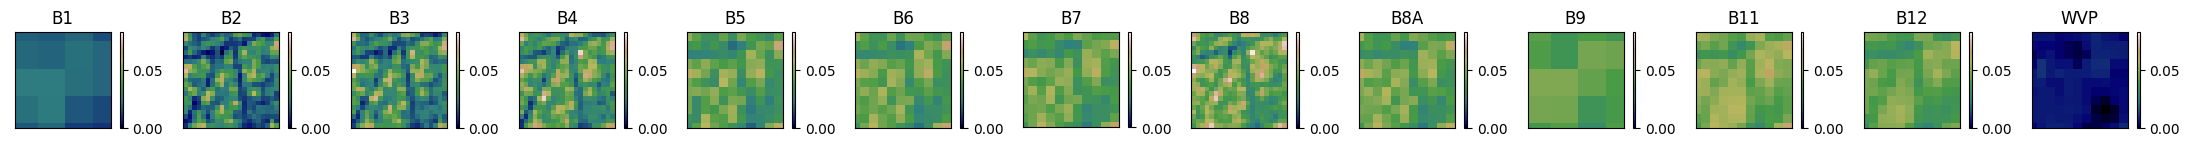

nonleak


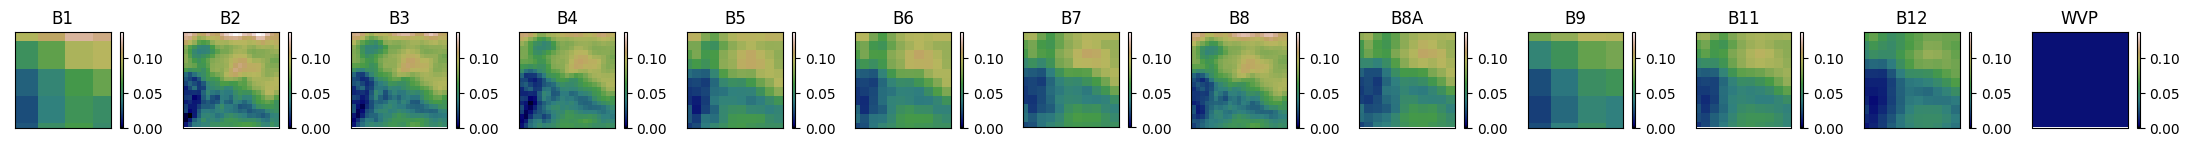

leak


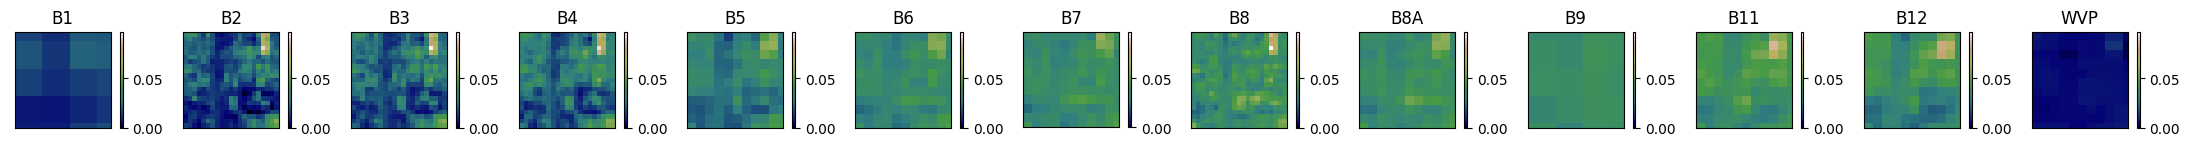

nonleak


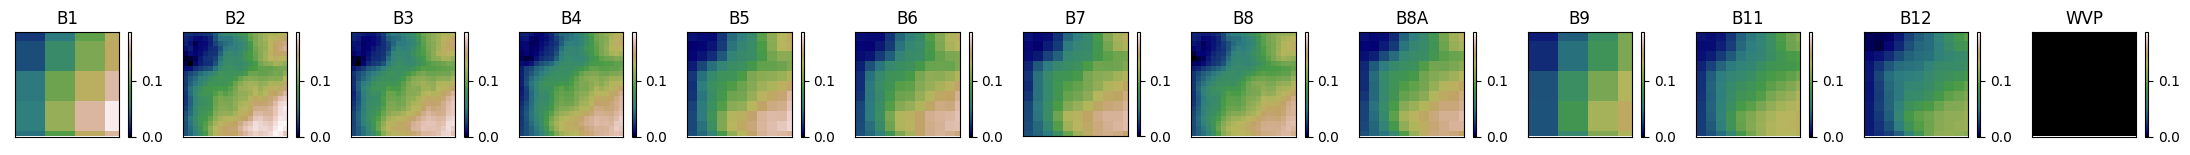

leak


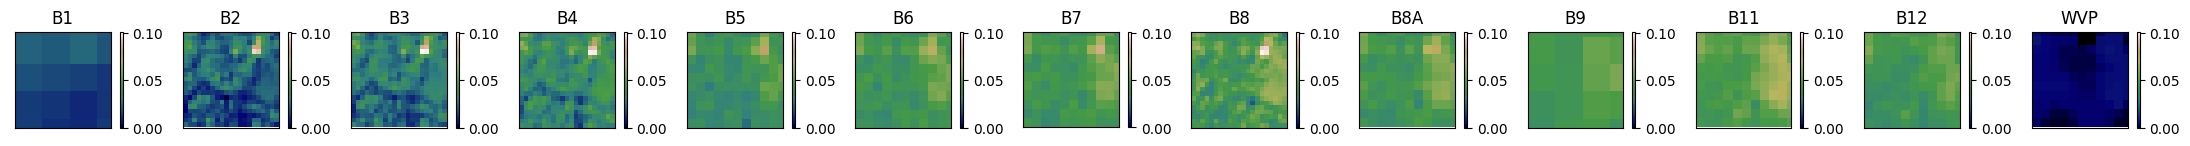

nonleak


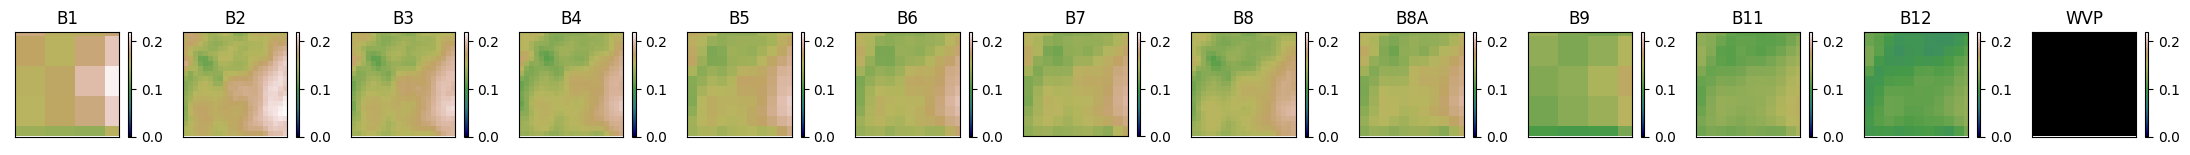

In [24]:
for i in range(0, 10):
    plot_bands(leak_images_paths[i], nonleak_images_paths[i])

### Land Surface Temperature plots

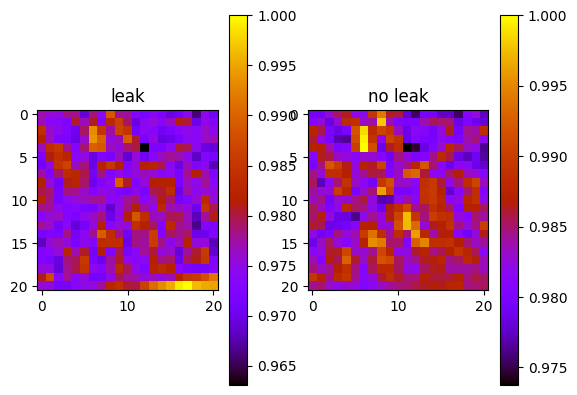

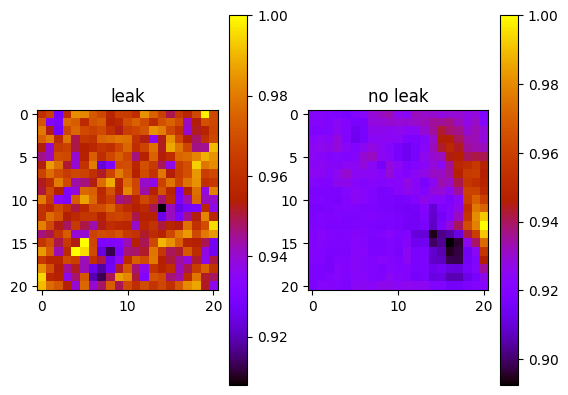

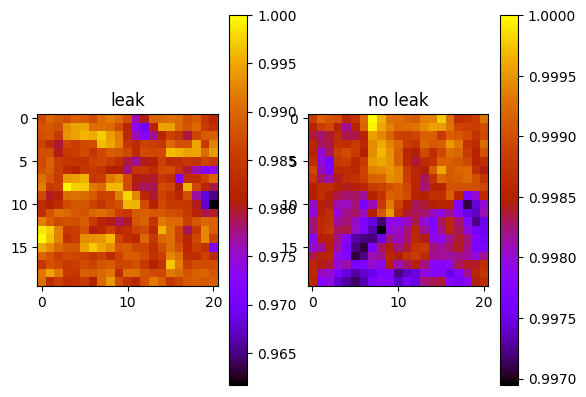

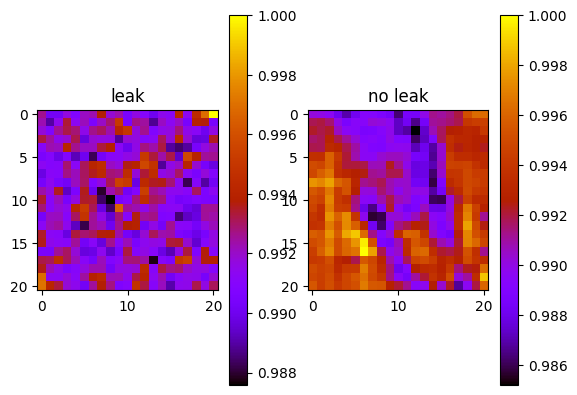

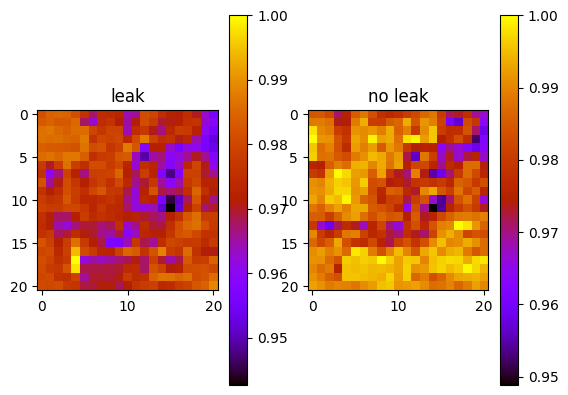

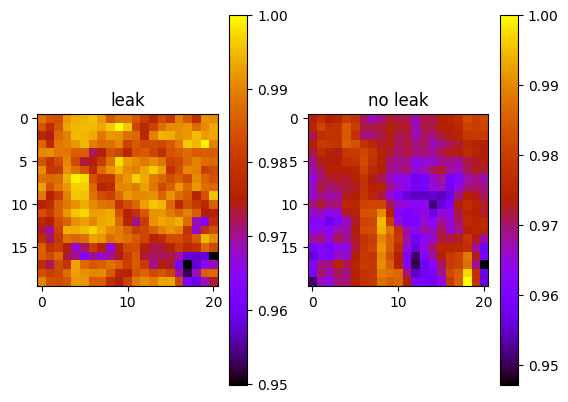

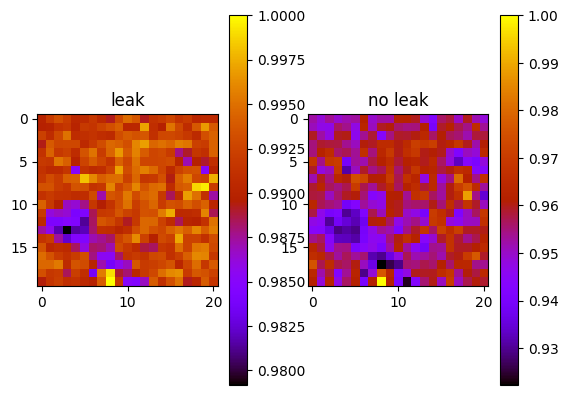

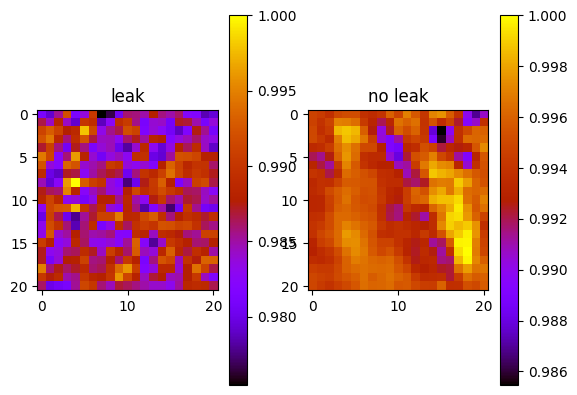

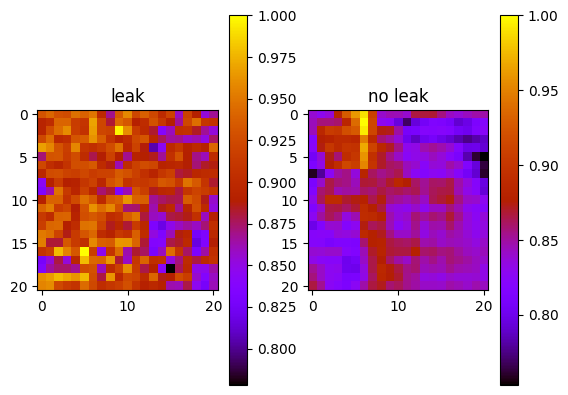

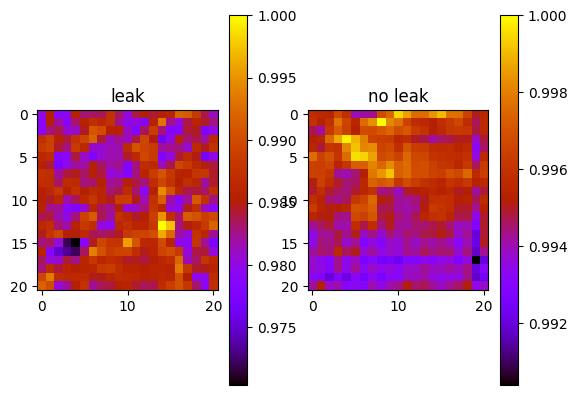

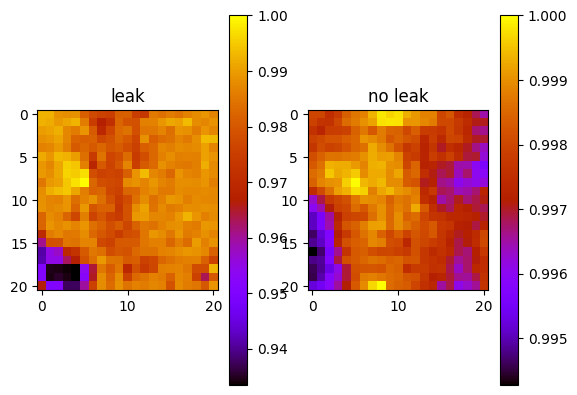

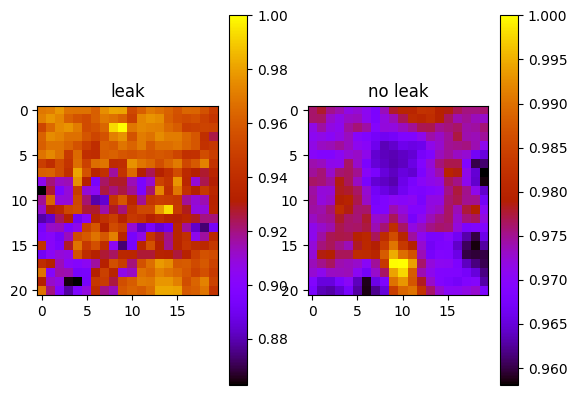

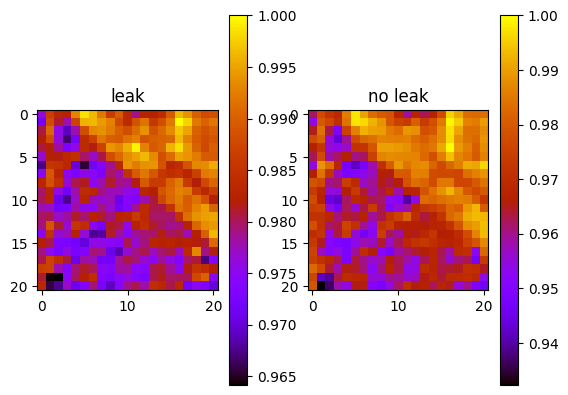

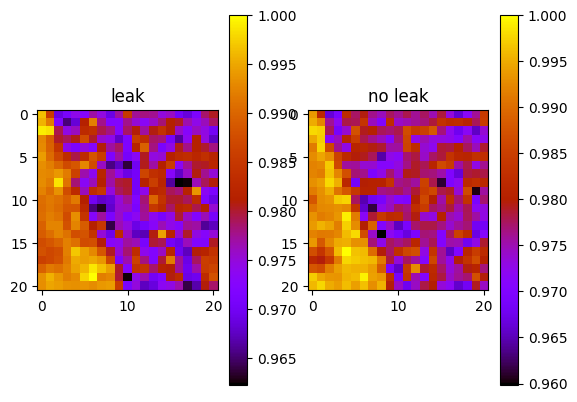

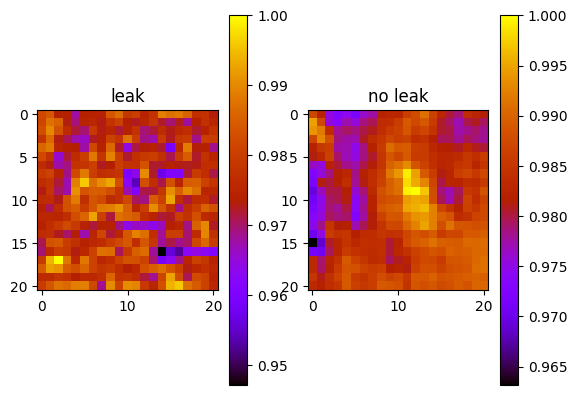

In [19]:
for i in range(0, 15):
    plot_lst(leak_images_paths[i], nonleak_images_paths[i])

### Histograms pixel per band

<Figure size 1200x100 with 0 Axes>

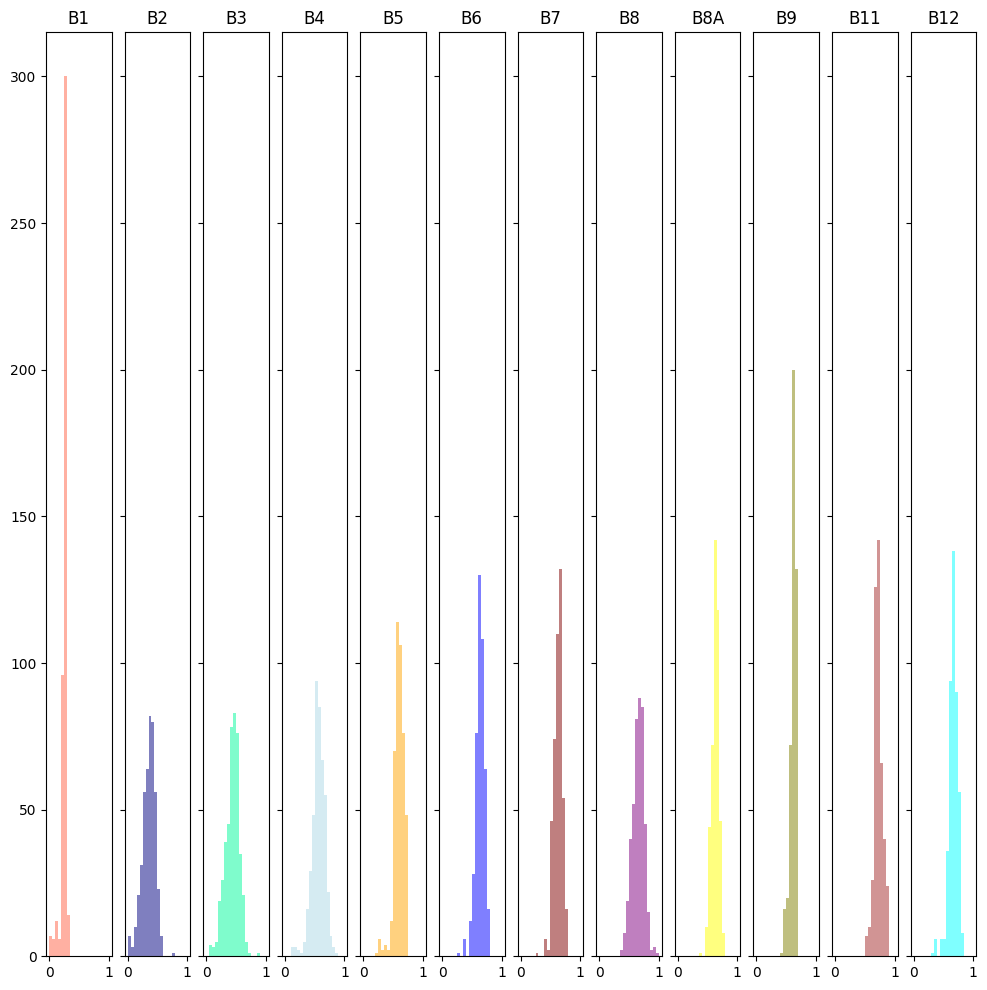

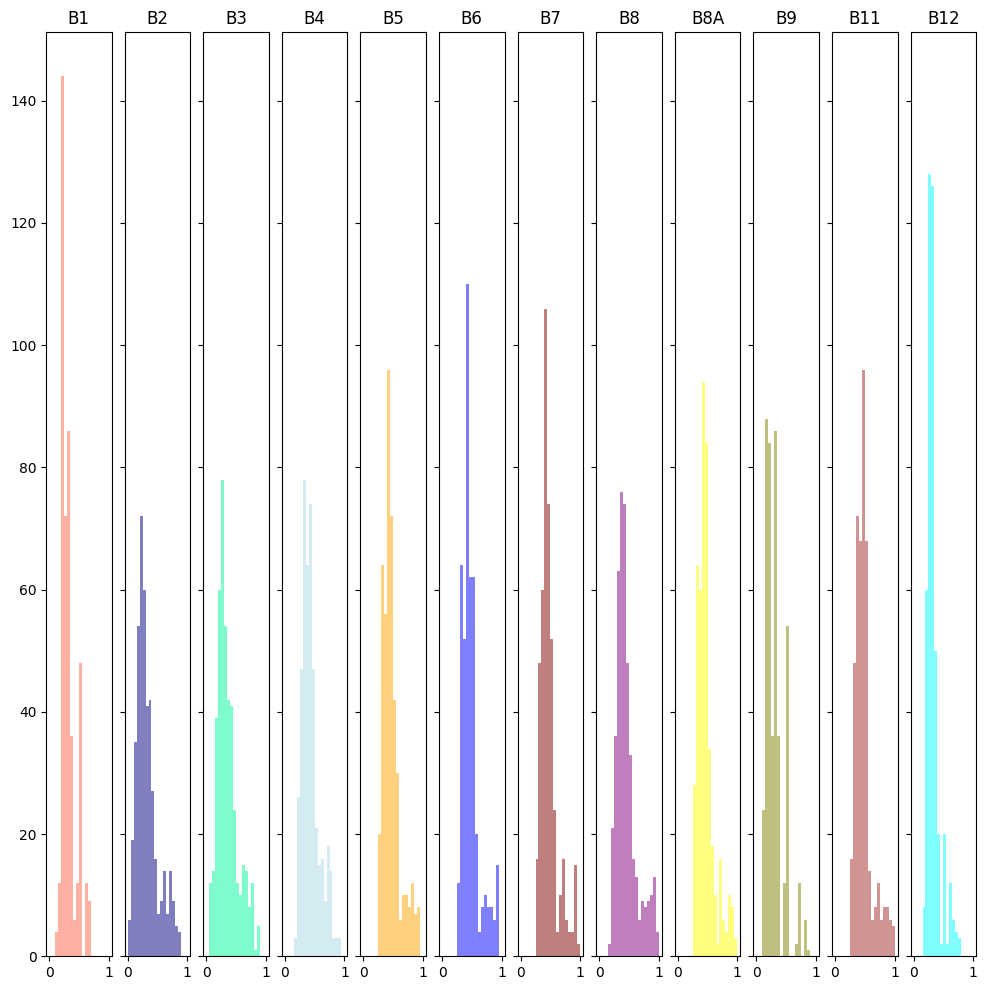

In [21]:
# histogram of pixels per band
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange',
        'blue', 'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan', "black", "red"]

fig = plt.figure(figsize = (12,1))

image_leak = read_tif(leak_images_paths[0])
image_nonleak = read_tif(nonleak_images_paths[0])

ep.hist(
    arr = norm_bands(np.transpose(image_leak[:, :, :12])), colors = colors,
    title = titles[:12], cols = 12,
    alpha = 0.5
)

ep.hist(
    arr = norm_bands(np.transpose(image_nonleak[:, :, :12])), colors = colors,
    title = titles[:12], cols = 12,
    alpha = 0.5
)

plt.show()

### Normalized Difference Moisture Index plots

$NDMI = (NIR - SWIR)/(NIR + SWIR) = (B08 - B11)/(B08 + B11)$

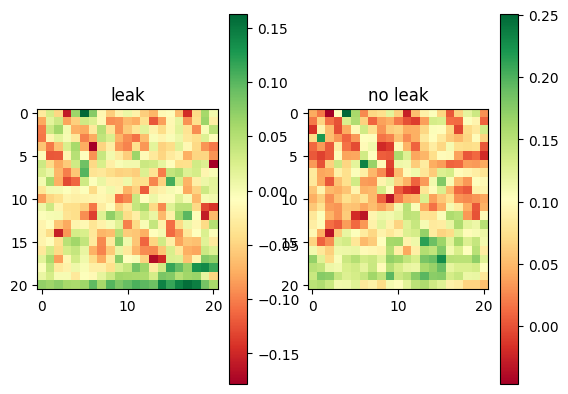

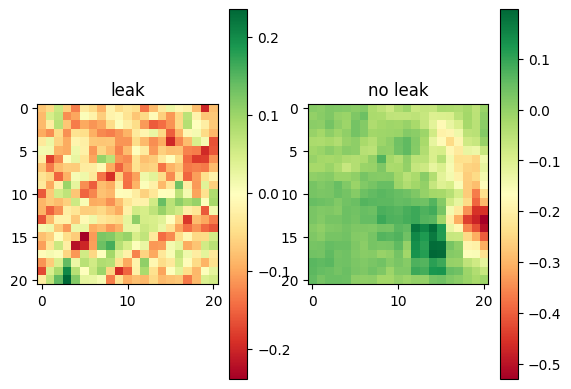

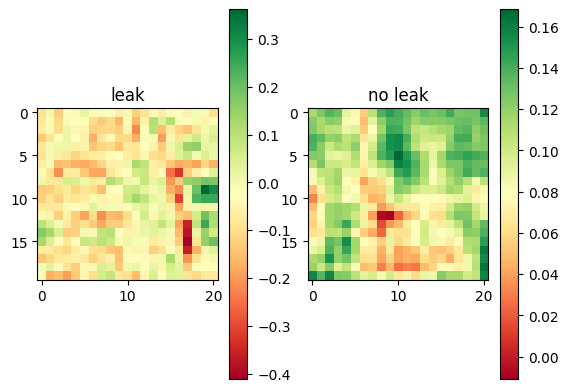

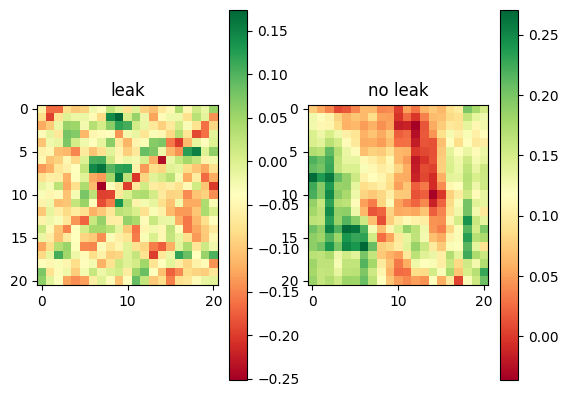

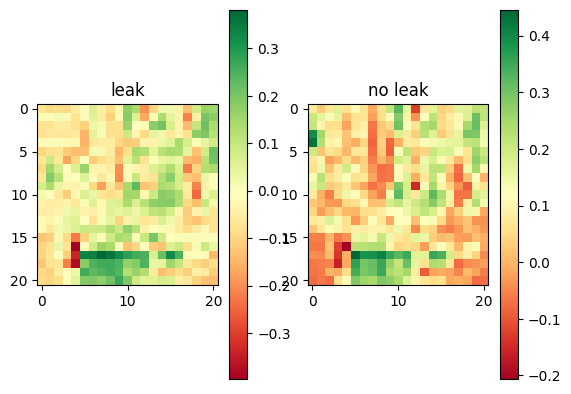

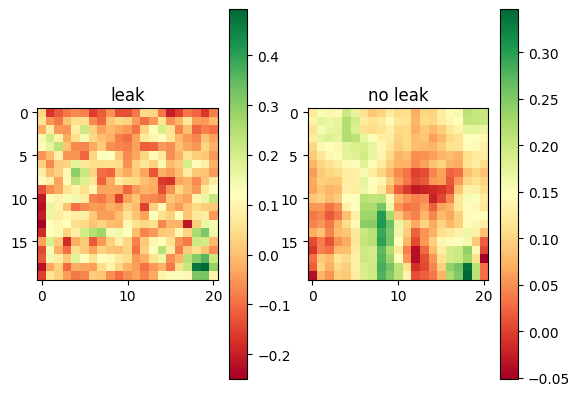

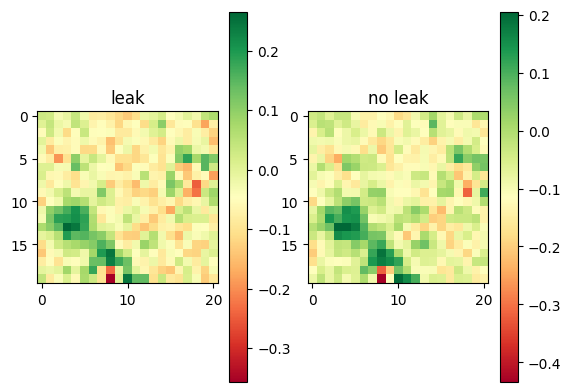

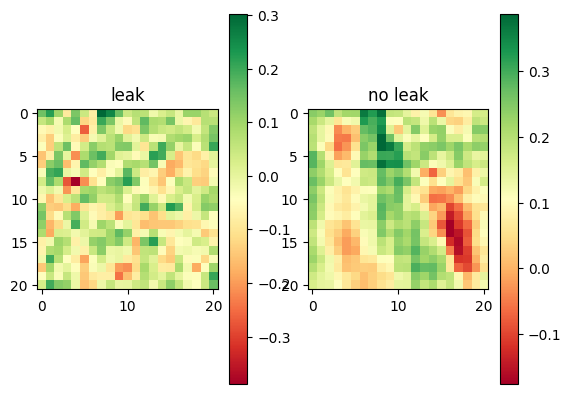

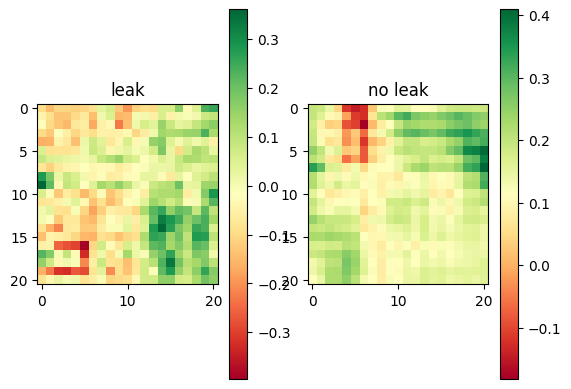

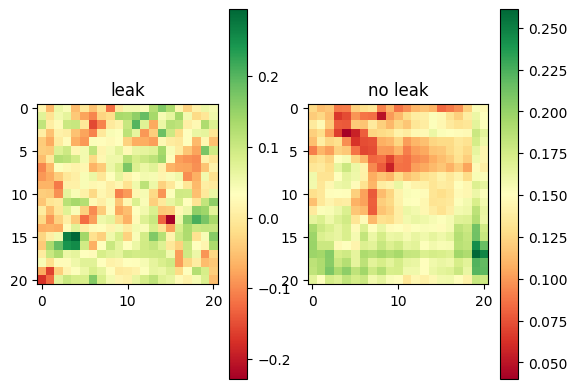

In [23]:
for i in range(0, 10):
    plot_ndmi(leak_tif_path = leak_images_paths[i], nonleak_tif_path = nonleak_images_paths[i])